In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Import data and cleaning

In [36]:
df = pd.read_csv('sorting_event_volumes_2023.csv')

In [38]:
df['scanning_date'] = pd.to_datetime(df['scanning_date'], errors='coerce')
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.dayofweek + 1
df['week'] = df['scanning_date'].dt.isocalendar().week
df['week_of_month'] = (df['day'] - 1) // 7 + 1


In [39]:
# Data cleaning
print("Number of rows is: " + str(df.shape[0]))

df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df['scanning_date'] = pd.to_datetime(df['scanning_date'])

print("Number of rows cleaned data is: " + str(df.shape[0]))

Number of rows is: 8949721


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_39256\1344708621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_39256\1344708621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_39256\1344708621.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

Number of rows cleaned data is: 7450939


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_39256\1344708621.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scanning_date'] = pd.to_datetime(df['scanning_date'])


In [41]:
def total_orders_per_day_by_center(df):
    centers = df['sorting_center_name'].unique()
    
    plt.figure(figsize=(15, 12))
    
    for center in centers:
        daily_totals = df[df['sorting_center_name'] == center].groupby('scanning_date')['no_of_events'].sum()
        plt.plot(daily_totals.index, daily_totals.values, marker='.', label=center, linewidth=0.5)  # Pas de dikte van de lijn aan

    plt.xlabel('Datum', fontsize=14)  # Pas de lettergrootte voor de x-as aan
    plt.ylabel('Totaal aantal bestellingen', fontsize=14)  # Pas de lettergrootte voor de y-as aan
    plt.title('Totaal aantal bestellingen per dag per sorting center', fontsize=16)  # Pas de lettergrootte voor de titel aan
    plt.xticks(rotation=45, fontsize=12)  # Pas de lettergrootte voor de x-as tick labels aan
    plt.legend(title='Sorting Centers', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # Pas de lettergrootte voor de legende aan
    plt.grid(True)
    plt.show()

# total_orders_per_day_by_center(df)



In [43]:
sorting_center_names = df['sorting_center_name'].unique()

def output_sums_and_normalized_per_day_by_belt(df, sorting_center_name, top_x=100):
    # Berekening van de dagelijkse totalen per output belt
    daily_totals = df[df['sorting_center_name'] == sorting_center_name].groupby(['scanning_date', 'output_belt'])['no_of_events'].sum().unstack()

    # Sorteren van de output belts op basis van het totale aantal bestellingen en selecteren van de top_x
    total_per_belt = daily_totals.sum().sort_values(ascending=False)
    top_belts = total_per_belt.head(top_x).index  # Selecteer de top_x output belts

    # Beperk de data tot de top_x output belts
    daily_totals_top = daily_totals[top_belts]

    # Berekening van de genormaliseerde percentages voor de top_x output belts
    daily_totals_normalized = daily_totals_top.div(daily_totals_top.sum(axis=1), axis=0) * 100

    # Filter dagen met een totaal aantal bestellingen lager dan een drempel (bijvoorbeeld 2000)
    daily_totals_normalized = daily_totals_normalized[daily_totals_top.sum(axis=1) > 0]

    # Creëer een figuur met 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Plot voor absolute aantallen
    daily_totals_top.plot(ax=ax1, marker='.', linewidth=0.4)  # Geen lijnen, alleen markers
    ax1.set_xlabel('')
    ax1.set_ylabel('Totaal aantal bestellingen', fontsize=14)
    ax1.set_title(f'Totaal aantal bestellingen per dag per output belt (Top {top_x}) voor {sorting_center_name}', fontsize=16)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.legend(title='Output Belts', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax1.grid(True)

    # Plot voor genormaliseerde percentages
    daily_totals_normalized.plot(ax=ax2, marker='.', linewidth=0.24)  # Geen lijnen, alleen markers
    ax2.set_xlabel('Datum', fontsize=14)
    ax2.set_ylabel('Percentage van totaal (%)', fontsize=14)
    ax2.set_title(f'Genormaliseerde bestellingen per dag per output belt (Top {top_x}) voor {sorting_center_name}', fontsize=16)
    ax2.set_ylim(0, 110)  # Beperk de y-as om kleine variaties beter zichtbaar te maken
    ax2.tick_params(axis='x', rotation=45, labelsize=12)
    ax2.legend(title='Output Belts', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax2.grid(True)

    # Toon de plot
    plt.tight_layout()
    plt.show()

# # Functie aanroepen voor elk sorting center in de lijst 'sorting_center_names'
# for name in sorting_center_names:
#     output_sums_and_normalized_per_day_by_belt(df, name, top_x=10)



In [44]:
summed_df = df.groupby(['sorting_center_name', 'output_belt', 'scanning_date'])['no_of_events'].sum().reset_index()
print(summed_df)

event_counts = summed_df['no_of_events'].value_counts().sort_index()
print(event_counts)

       sorting_center_name  output_belt scanning_date  no_of_events
0                   KUOPIO            0    2023-01-02          1439
1                   KUOPIO            0    2023-01-03          1109
2                   KUOPIO            0    2023-01-04          1073
3                   KUOPIO            0    2023-01-05          1034
4                   KUOPIO            0    2023-01-09          1813
...                    ...          ...           ...           ...
188623              VANTAA          351    2023-12-21           291
188624              VANTAA          351    2023-12-22           189
188625              VANTAA          351    2023-12-27           412
188626              VANTAA          351    2023-12-28           293
188627              VANTAA          351    2023-12-29           255

[188628 rows x 4 columns]
no_of_events
1        3356
2        2569
3        2014
4        1563
5        1366
         ... 
21714       1
22021       1
22709       1
23114       1
2376

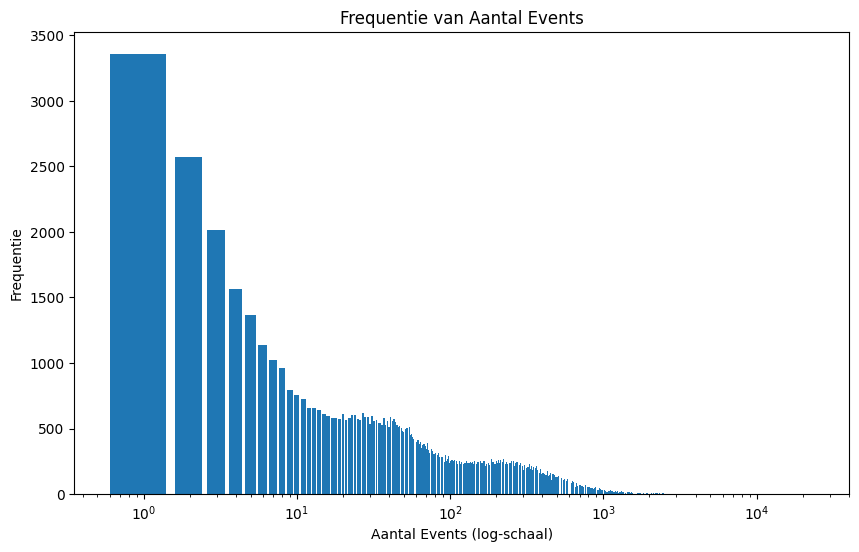

In [45]:
import matplotlib.pyplot as plt

# Bestaande code om de som van 'no_of_events' te berekenen
summed_df = df.groupby(['sorting_center_name', 'output_belt', 'scanning_date'])['no_of_events'].sum().reset_index()

# Event counts
event_counts = summed_df['no_of_events'].value_counts().sort_index()

# Plotten met log-schaal
plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values)
plt.xscale('log')
plt.xlabel('Aantal Events (log-schaal)')
plt.ylabel('Frequentie')
plt.title('Frequentie van Aantal Events')
plt.show()



In [7]:
dfs = {}

for name, group in df.groupby('sorting_center_name'):
    df_grouped = group.groupby(['scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum()
    df_grouped = df_grouped.merge(group[['scanning_date', 'day', 'month', 'weekday', 'week', 'week_of_month']].drop_duplicates(), 
                                  on='scanning_date', 
                                  how='left')
    dfs[name] = df_grouped




In [8]:
df_VANTAA = dfs['VANTAA']
df_LIETO = dfs['LIETO']
df_TAMPERE = dfs['TAMPERE']
df_SEINÄJOKI = dfs['SEINÄJOKI']
df_KUOPIO = dfs['KUOPIO']
df_OULU = dfs['OULU']

In [9]:
df = dfs['VANTAA']
df

,scanning_date,output_belt,no_of_events,day,month,weekday,week,week_of_month
0,2023-01-02,0,1,2,1,1,1,1
1,2023-01-02,1,533,2,1,1,1,1
2,2023-01-02,2,256,2,1,1,1,1
3,2023-01-02,3,1422,2,1,1,1,1
4,2023-01-02,4,1684,2,1,1,1,1
...,...,...,...,...,...,...,...,...
44001,2023-12-30,96,956,30,12,6,52,5
44002,2023-12-30,97,692,30,12,6,52,5
44003,2023-12-30,98,929,30,12,6,52,5
44004,2023-12-30,99,47,30,12,6,52,5


In [46]:
import pandas as pd
import numpy as np

# Voeg alle mogelijke data (unieke combinaties van dagen en output_belts) toe aan de dataset
def fill_missing_events(df):
    # Genereer een reeks van alle unieke dagen in de dataset
    all_dates = pd.date_range(start=df['scanning_date'].min(), end=df['scanning_date'].max())

    # Genereer een DataFrame met alle mogelijke combinaties van dagen en output_belts
    all_combinations = pd.MultiIndex.from_product([all_dates, df['output_belt'].unique()], names=['scanning_date', 'output_belt'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()

    # Merge met de originele DataFrame om ontbrekende combinaties toe te voegen met een waarde van 0 voor 'no_of_events'
    df_filled = pd.merge(all_combinations_df, df, on=['scanning_date', 'output_belt'], how='left')
    df_filled['no_of_events'] = df_filled['no_of_events'].fillna(0)

    # Voeg extra tijdsgegevens toe indien nodig (zoals 'day', 'month', etc.)
    df_filled['day'] = df_filled['scanning_date'].dt.day
    df_filled['month'] = df_filled['scanning_date'].dt.month
    df_filled['weekday'] = df_filled['scanning_date'].dt.dayofweek + 1
    df_filled['week'] = df_filled['scanning_date'].dt.isocalendar().week
    df_filled['week_of_month'] = (df_filled['day'] - 1) // 7 + 1

    return df_filled

# Pas de functie toe op elk DataFrame
df_VANTAA = fill_missing_events(df_VANTAA)
df_LIETO = fill_missing_events(df_LIETO)
df_TAMPERE = fill_missing_events(df_TAMPERE)
df_SEINÄJOKI = fill_missing_events(df_SEINÄJOKI)
df_KUOPIO = fill_missing_events(df_KUOPIO)
df_OULU = fill_missing_events(df_OULU)


In [49]:
df = df_VANTAA

## Embeddings

In [51]:
# Voeg 'week_of_month' toe aan de combinatie van categorische features
df['category_comb'] = (
    df['output_belt'].astype(str) + '_' + 
    df['day'].astype(str) + '_' + 
    df['weekday'].astype(str) + '_' + 
    df['week_of_month'].astype(str)
)

# Encodeer de gecombineerde categorieën
df['category_encoded'] = df['category_comb'].astype('category').cat.codes
df


,scanning_date,output_belt,no_of_events,day,month,weekday,week,week_of_month,category_comb,category_encoded
0,2023-01-02,0,1.0,2,1,1,1,1,0_2_1_1,147
1,2023-01-02,1,533.0,2,1,1,1,1,1_2_1_1,2942
2,2023-01-02,2,256.0,2,1,1,1,1,2_2_1_1,5307
3,2023-01-02,3,1422.0,2,1,1,1,1,3_2_1_1,18852
4,2023-01-02,4,1684.0,2,1,1,1,1,4_2_1_1,21217
...,...,...,...,...,...,...,...,...,...,...
54445,2023-12-30,315,0.0,30,12,6,52,5,315_30_6_5,8974
54446,2023-12-30,316,0.0,30,12,6,52,5,316_30_6_5,9189
54447,2023-12-30,302,0.0,30,12,6,52,5,302_30_6_5,5964
54448,2023-12-30,99,47.0,30,12,6,52,5,99_30_6_5,31979


In [53]:
class EventDataset(Dataset):
    def __init__(self, df):
        self.data = df
        self.inputs = torch.tensor(self.data['category_encoded'].values, dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values, dtype=torch.float32)
        self.output_belt = self.data['output_belt'].values  # Bewaar de output_belt-waarden

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], torch.tensor(self.output_belt[idx], dtype=torch.long)


In [54]:
class SimpleNN(nn.Module):
    def __init__(self, num_categories, embedding_dim):
        super(SimpleNN, self).__init__()
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        # print(x.shape)
        # print(x[0])
        x = self.embedding(x)
        x = self.bn1(torch.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(torch.relu(self.fc2(x)))
        x = self.bn3(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

import torch.nn.functional as F




In [116]:
from sklearn.model_selection import train_test_split

method = 'sequential'

def split_dataset(df, method=method, test_size=1):
    if method == 'random':
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    else:  # 'sequential'
        start_test, end_test = 0.75, test_size
        test_df = df.iloc[int(start_test * len(df)):int(end_test * len(df))]
        train_df = pd.concat([df.iloc[:int(start_test * len(df))], df.iloc[int(end_test * len(df)):]])
    return train_df, test_df

train_df, test_df = split_dataset(df, method=method)

train_loader = DataLoader(EventDataset(train_df), batch_size=512, shuffle=False)
test_loader = DataLoader(EventDataset(test_df), batch_size=512, shuffle=True)


In [117]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [118]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=5, min_delta=0.01):
    train_losses, test_losses = [], []
    early_stopping_counter = 0  # Teller om het aantal niet-verbeterende epochs bij te houden

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _ in train_loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs).squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        # avg_train_loss = (running_loss / len(train_loader)) ** 0.5  # Vierkantswortel voor RMSE
        train_losses.append(avg_train_loss)
        
        # Evaluatie
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for inputs, targets, _ in test_loader:
                inputs = inputs.to(device)
                targets = targets.float().to(device)
                total_loss += criterion(model(inputs).squeeze(), targets).item()
        avg_test_loss = (total_loss / len(test_loader))
        # avg_test_loss = (total_loss / len(test_loader))**0.5 # Vierkantswortel voor RMSE
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early Stopping logica
        if epoch >= patience:
            if avg_test_loss > test_losses[-patience]:  # Vergelijk met de test loss van `patience` epochs geleden
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0  # Reset de teller als er verbetering is
        
            if early_stopping_counter >= patience:
                print(f'Early stopping na {epoch + 1} epochs.')
                break


    return train_losses, test_losses



Epoch [1/200], Train Loss: 709.9275, Test Loss: 795.3734, LR: 0.030000
Epoch [2/200], Train Loss: 619.0622, Test Loss: 662.8126, LR: 0.030000
Epoch [3/200], Train Loss: 507.3017, Test Loss: 567.5616, LR: 0.030000
Epoch [4/200], Train Loss: 426.2280, Test Loss: 511.0786, LR: 0.030000
Epoch [5/200], Train Loss: 382.7052, Test Loss: 477.8764, LR: 0.030000
Epoch [6/200], Train Loss: 352.0309, Test Loss: 451.6520, LR: 0.030000
Epoch [7/200], Train Loss: 330.4344, Test Loss: 437.1939, LR: 0.030000
Epoch [8/200], Train Loss: 314.2401, Test Loss: 431.5068, LR: 0.030000
Epoch [9/200], Train Loss: 304.8542, Test Loss: 426.7408, LR: 0.030000
Epoch [10/200], Train Loss: 298.5910, Test Loss: 414.7277, LR: 0.030000
Epoch [11/200], Train Loss: 291.7328, Test Loss: 415.2605, LR: 0.030000
Epoch [12/200], Train Loss: 287.6292, Test Loss: 401.3481, LR: 0.030000
Epoch [13/200], Train Loss: 284.1822, Test Loss: 403.0482, LR: 0.030000
Epoch [14/200], Train Loss: 280.9663, Test Loss: 404.1914, LR: 0.030000
E

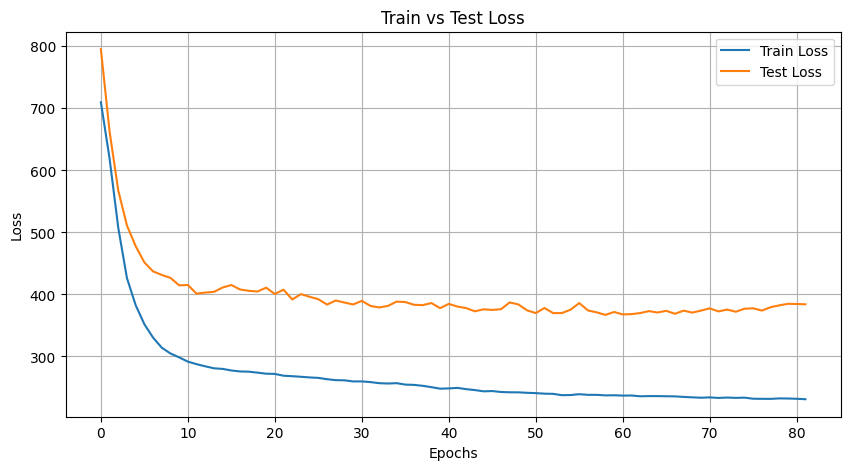

In [119]:
num_categories = len(df['category_encoded'].unique())
embedding_dim = 4

model = SimpleNN(num_categories=num_categories, embedding_dim=embedding_dim).to(device)
criterion = nn.L1Loss()
# criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.03)

train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=200)
plot_losses(train_losses, test_losses)

## Old way of validating results

In [87]:
# import random
# import matplotlib.pyplot as plt

# # Kies willekeurig 3 output_belts om te plotten
# output_belts_to_plot = random.sample(df['output_belt'].unique().tolist(), 3)

# # Aantal batches dat je wilt visualiseren
# num_batches = 10

# # Haal meerdere batches op uit de test_loader
# for batch_idx, (inputs, targets, output_belts) in enumerate(test_loader):
#     if batch_idx >= num_batches:
#         break

#     # Zet alle tensors naar de juiste device en haal waarden op
#     inputs = inputs.to(device)
#     targets = targets.float().to(device)
#     outputs = model(inputs).squeeze().cpu().detach().numpy()
#     targets = targets.cpu().numpy()
#     output_belts = output_belts.cpu().numpy()

#     # Loop over elke geselecteerde output_belt
#     for belt in output_belts_to_plot:
#         # Filter de voorbeelden op de huidige output_belt
#         mask = output_belts == belt
#         belt_outputs = outputs[mask]
#         belt_targets = targets[mask]

#         # Controleer of er gegevens zijn om te plotten
#         if len(belt_outputs) == 0:
#             continue

#         # Maak de plot voor de huidige output_belt
#         plt.figure(figsize=(15, 5))
#         plt.plot(belt_targets, label='Targets', alpha=0.7)
#         plt.plot(belt_outputs, label='Outputs', alpha=0.7)
#         plt.plot(belt_outputs - belt_targets, label='Difference (Output - Target)', linestyle='--', alpha=0.7)

#         plt.xlabel('Voorbeeld Index')
#         plt.ylabel('Waarde')
#         plt.title(f'Batch {batch_idx + 1}, Output Belt {belt}: Targets vs Outputs vs Difference')
#         plt.legend()
#         plt.grid(True)
#         plt.show()


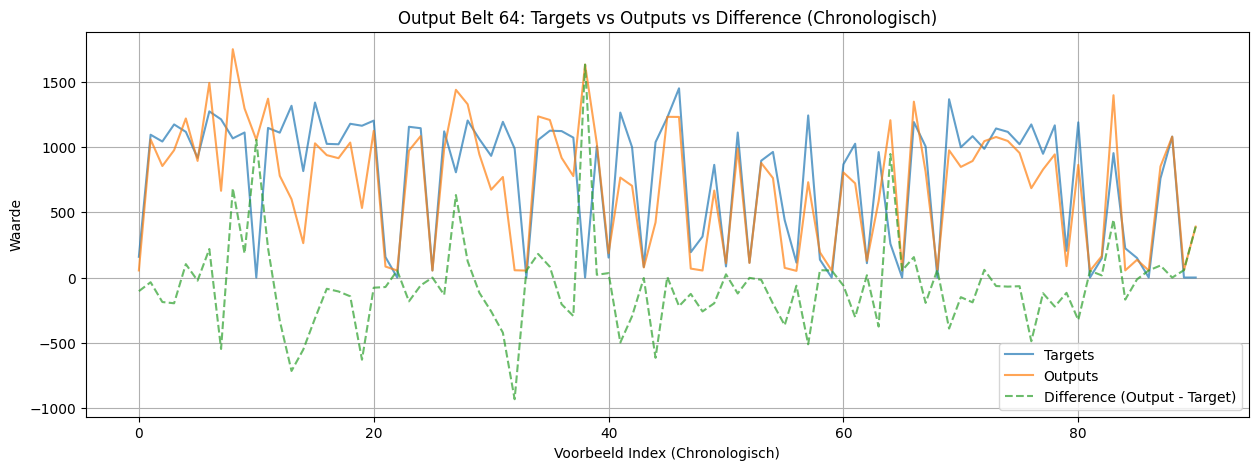

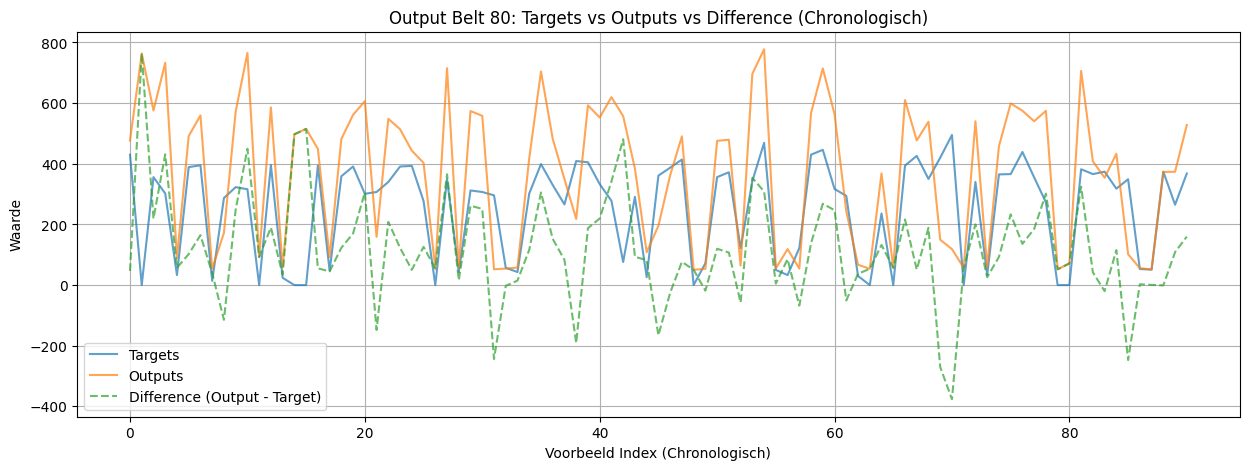

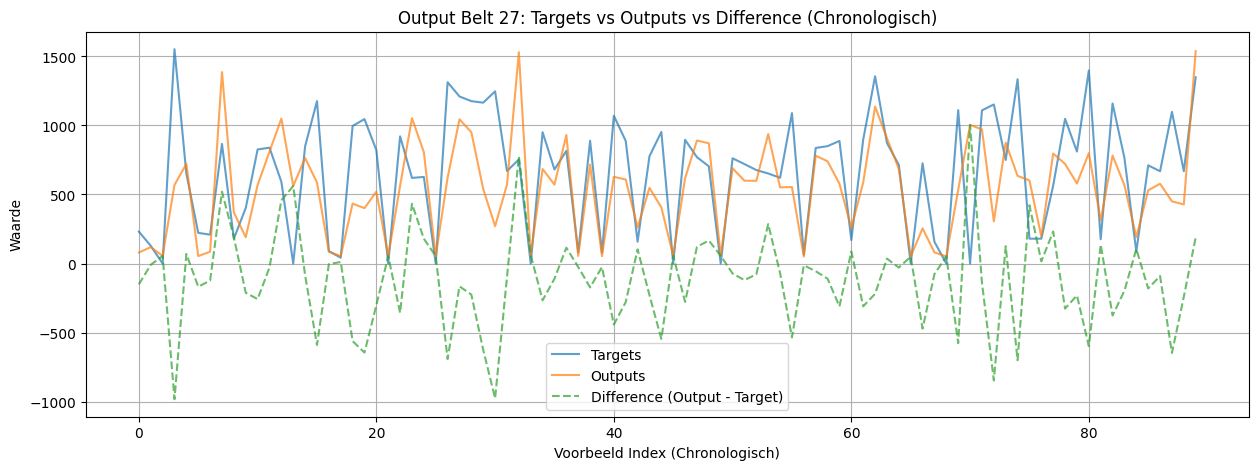

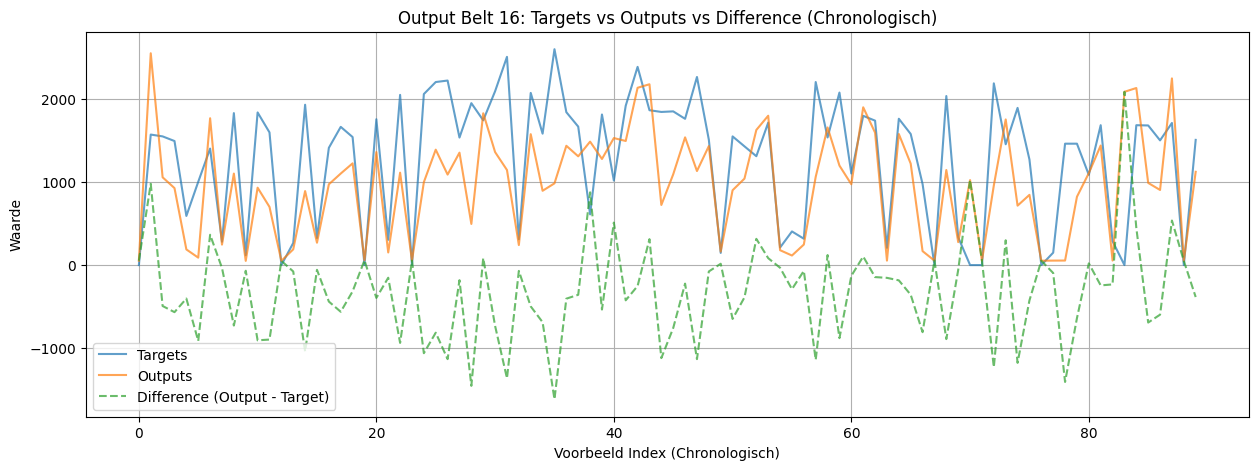

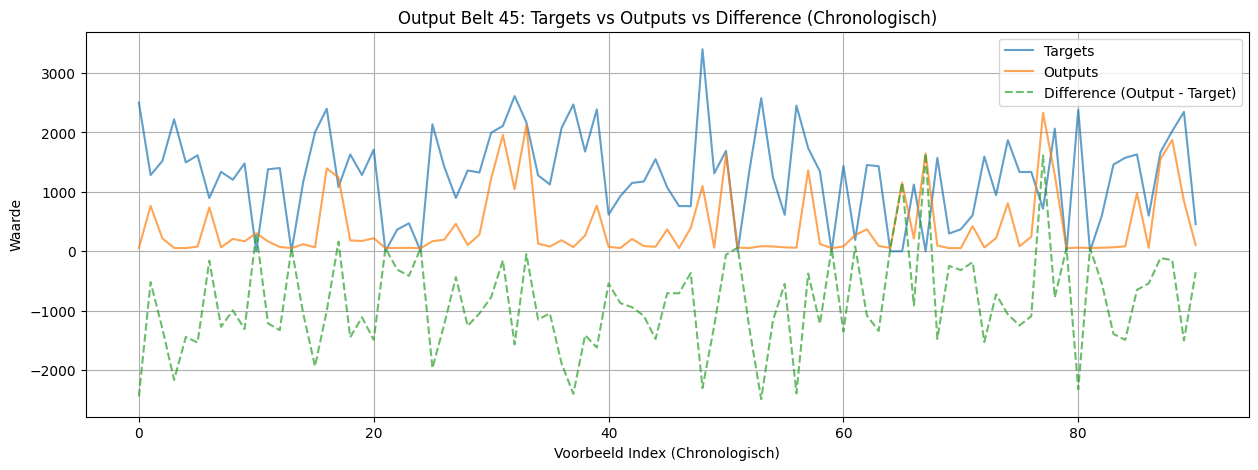

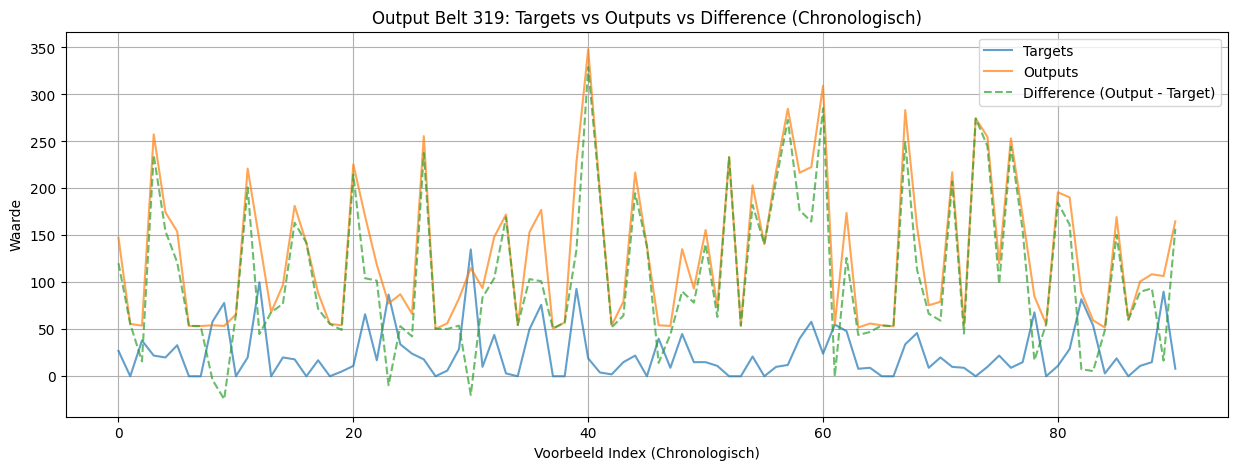

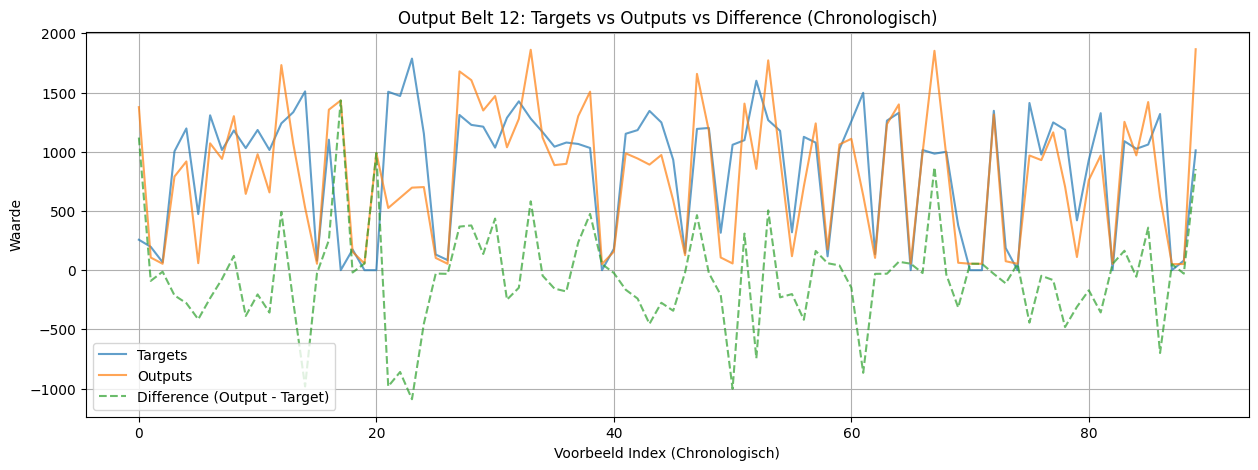

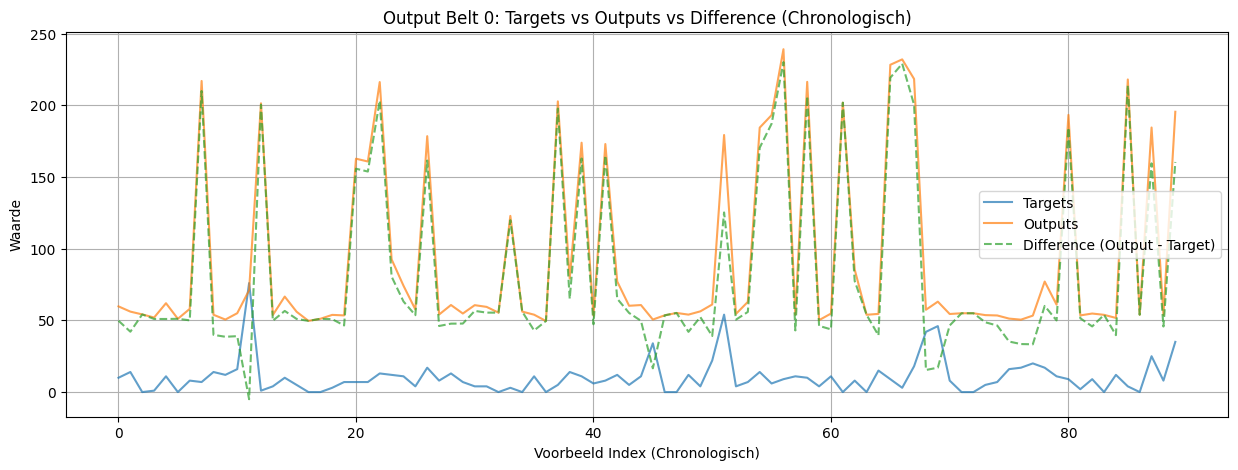

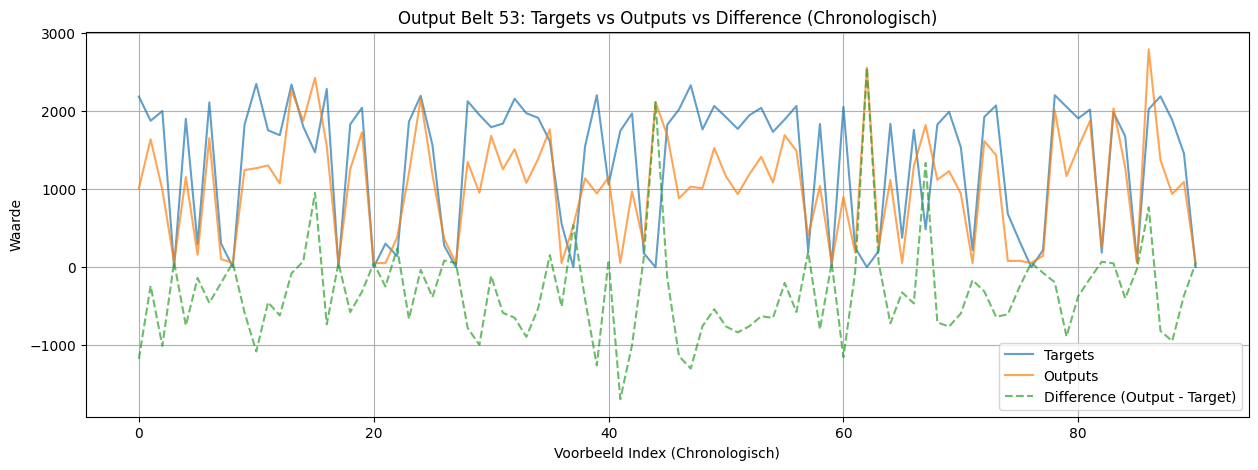

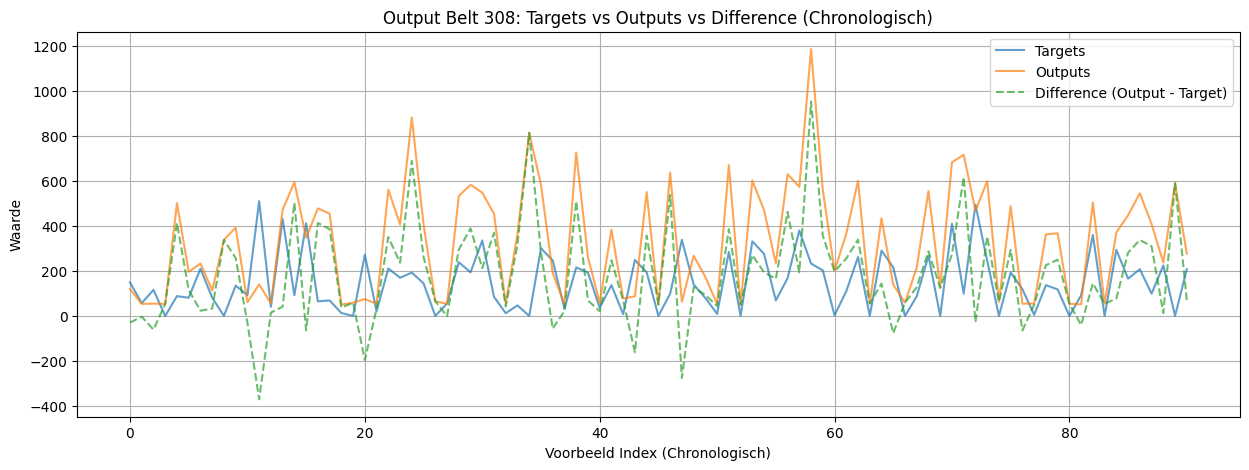

In [120]:
import random
import matplotlib.pyplot as plt

# Kies willekeurig 3 output_belts uit de training set om te plotten
output_belts_to_plot = random.sample(df['output_belt'].unique().tolist(), 10)
# output_belts_to_plot = [0, 109, 2] 

# Lijsten om alle voorspellingen, targets en output_belts van de testset op te slaan
all_outputs = []
all_targets = []
all_output_belts = []

# Haal de volledige testset op en sla outputs en targets op
for inputs, targets, output_belts in test_loader:
    inputs = inputs.to(device)
    targets = targets.float().to(device)
    outputs = model(inputs).squeeze().cpu().detach().numpy()
    targets = targets.cpu().numpy()
    output_belts = output_belts.cpu().numpy()
    
    all_outputs.append(outputs)
    all_targets.append(targets)
    all_output_belts.append(output_belts)

# Zet alles in één array
all_outputs = np.concatenate(all_outputs)
all_targets = np.concatenate(all_targets)
all_output_belts = np.concatenate(all_output_belts)

# Loop over elke geselecteerde output_belt en plot chronologisch
for belt in output_belts_to_plot:
    # Filter de voorbeelden op de huidige output_belt
    mask = all_output_belts == belt
    belt_outputs = all_outputs[mask]
    belt_targets = all_targets[mask]

    # Controleer of er gegevens zijn om te plotten
    if len(belt_outputs) == 0:
        continue

    # Maak de plot voor de huidige output_belt
    plt.figure(figsize=(15, 5))
    plt.plot(belt_targets, label='Targets', alpha=0.7)
    plt.plot(belt_outputs, label='Outputs', alpha=0.7)
    plt.plot(belt_outputs - belt_targets, label='Difference (Output - Target)', linestyle='--', alpha=0.7)

    plt.xlabel('Voorbeeld Index (Chronologisch)')
    plt.ylabel('Waarde')
    plt.title(f'Output Belt {belt}: Targets vs Outputs vs Difference (Chronologisch)')
    plt.legend()
    plt.grid(True)
    plt.show()
